# Summary
This notebook illustrates the thought process when planning a machine learning solution to classification of Malaria images.

Some important assumptions are made:
- we can normalize the image dataset in a number of ways with neglible loss of model quality and usablity
    - color to grayscale conversion
    - scaling (possibly large, rectangle shaped) images to small rectangles

We partition the full dataset (27558 labelled images) into subsets:
- 20% for training
- 5% for validation during training
- 25% for validation of model after training

The above simplifications (?) allows us to work efficiently in an iterative and explorative manner, and we end up with a model with a performance of
- ~ 92% precision
- ~ 95% recall
- ~ 93% F1 score

# Notebook preparation

## Install dependencies

In [378]:
%%capture
%pip install numpy pandas tensorflow tensorflow_datasets matplotlib seaborn keras_tuner

## Import code dependencies

In [379]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import Dataset
import seaborn as sns
print('Packages imported successfully');

Packages imported successfully


In [380]:
def print_versions():
  print('tensorflow: ', tf.__version__)
  print('tensorflow_datasets: ', tfds.__version__)

print_versions()

tensorflow:  2.17.0
tensorflow_datasets:  4.9.6


# Load and examine dataset 
Download [The Malaria dataset](https://www.tensorflow.org/datasets/catalog/malaria)

In [381]:
ds, info = tfds.load('malaria', split='train', shuffle_files=False, with_info=True)

## Verify that the dataset conforms to documentation
The metadata _features_ and _splits_ are according to documenation expected to be similar to
```
info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}
```
This fits our expectation that the data contains a training set consisting of nand valiumerically (0, 1) labelled images.
The dataset has only a single split, so we have to devise a strategy for splitting into train, test and validation.

In [382]:
print('info.features=', info.features)
print('info.splits=', info.splits)

info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}


## Understanding the dataset

### Preview a sample from the dataset

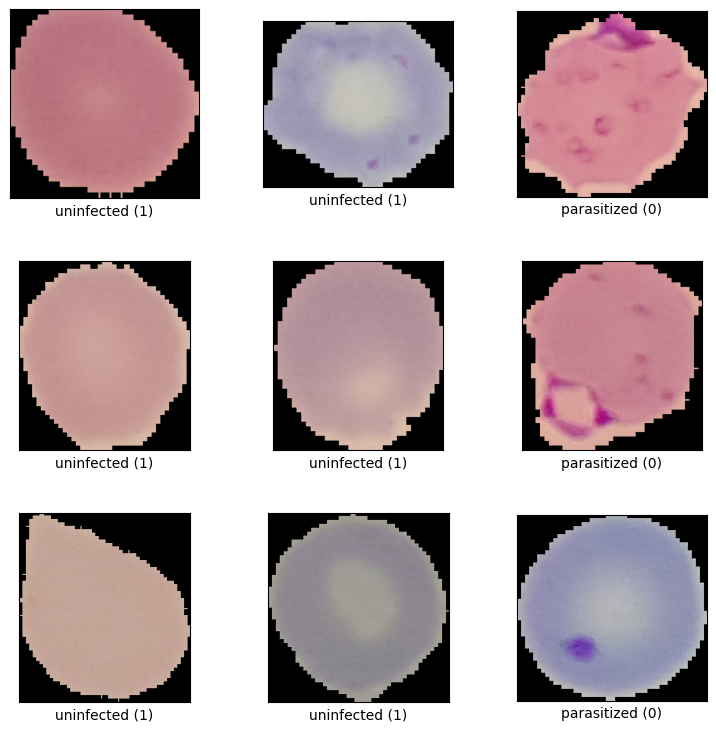

In [383]:
tfds.show_examples(ds, info, rows=3, cols=3);

From the above samples we can conclude that
- images are color encoded
- base colors differ
- the images seems to be carefully cropped
- the images are pure and free from artifacts such as qr-codes, watermarks or other annotations
- the images varies in size
- not all images are quadratic

### Statistical analysis

#### The dataset is balanced

The labels are 0 or 1, corresponding to _parazitized_ and _unifected_.

In [384]:
info.features['label'].names

['parasitized', 'uninfected']

Furthermore, the distribution of the images over the label is well balanced.

<Axes: title={'center': 'Image count per label'}, xlabel='label', ylabel='image count'>

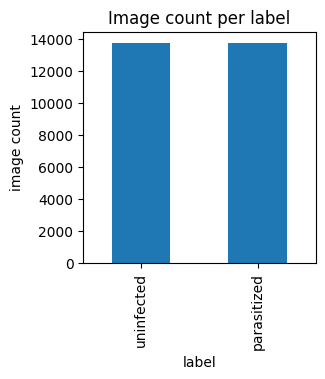

In [385]:
def get_label_name(label: int) -> str:
    return info.features['label'].names[label]

(DataFrame({
    'label': [get_label_name(d['label'].numpy()) for d in ds]
    })['label']
    .value_counts()
    .plot.bar(title='Image count per label', figsize=(3,3), ylabel='image count', xlabel='label'))

#### Investigation of image dimensions

The images are reperesented by [tensorflow tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor). Individual color channels (RGB) are encoded as unsigned bytes.

In [386]:
from scipy import stats
for image in ds.take(1):
  print('Image color channel range: ', stats.describe((image['image'].numpy().flatten())).minmax)
  print('Image encoding: ', image['image'])


Image color channel range:  (0, 218)
Image encoding:  tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8)


Extract width, height, aspect ratio and size for each image and print a basic statistical analysis.

                size         width        height  aspect ratio
count   27558.000000  27558.000000  27558.000000  27558.000000
mean    53507.269105    132.983453    132.487154      1.013867
std     14902.714162     20.619650     20.015949      0.150037
min      6600.000000     40.000000     46.000000      0.385366
25%     44202.000000    121.000000    121.000000      0.925000
50%     51870.000000    130.000000    130.000000      1.000000
75%     60465.000000    145.000000    142.000000      1.086331
max    371280.000000    385.000000    394.000000      2.184211
[Text(0.5, 1.0, 'Image width and height')]


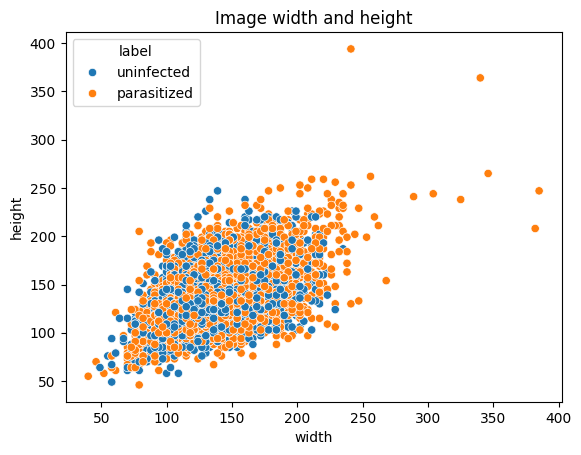

In [387]:
def get_image_characteristics(ds: tf.data.Dataset, sample_size: int) -> DataFrame:
  labels = [get_label_name(d['label'].numpy()) for d in ds.take(sample_size)]
  image_size_width_height = [(
    len(d['image'].numpy().flatten()),
    d['image'].shape[0],
    d['image'].shape[1],
  ) for d in ds.take(sample_size)]

  return DataFrame({
    'label': labels,
    'size': [t[0] for t in image_size_width_height],
    'width': [t[1] for t in image_size_width_height],
    'height': [t[2] for t in image_size_width_height],
    'aspect ratio': [t[1]/t[2] for t in image_size_width_height],
  })

print(get_image_characteristics(ds,-1).describe())
print(sns.scatterplot(get_image_characteristics(ds, -1), x='width', y='height', hue='label').set(title='Image width and height'))

We can conclude that
- there is a big span in size
- there is also some variation in dimensions and geometry
- although some parazitized images with witdh > 250 and height > 250 could be considered outlayers, we do not exlude them sinse they dont show any more variation regarding aspect ratio that imges in the main cluster.

To avoid overtraining due to external image characteristics, its wise to normalize with regards to size. This is probably best achieved by scaling images to a sensible size such as (121,121) which is smaller than (roughly) 75% of all images.

array([<Axes: >], dtype=object)

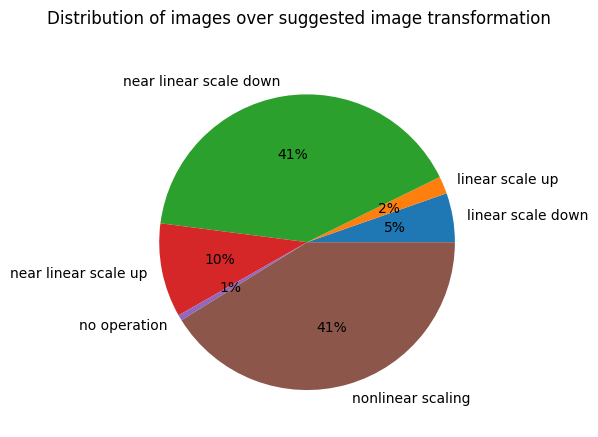

In [388]:
def get_image_characteristics_with_suggested_transform(ds: tf.data.Dataset, sample_size: int, d: int) -> DataFrame:
    def get_operation(actualw: int, actualh: int):
        if actualw/actualh == 1.0:
            return 'no operation' if actualw == d else 'linear scale up' if actualh < d else 'linear scale down'
        if abs(actualw/actualh - 1.0) < 0.1:
            return 'near linear scale up' if actualh < d else 'near linear scale down'
        return 'nonlinear scaling'

    df = get_image_characteristics(ds, sample_size)
    df['image transform'] = df.apply(lambda row: get_operation(row['width'], row['height']), axis=1)
    return df

(get_image_characteristics_with_suggested_transform(ds,-1, 121)
    .groupby('image transform')['image transform'].count()
    .plot.pie(x='image transform', subplots=True, autopct='%.0f%%', title='Distribution of images over suggested image transformation', xlabel='', ylabel=''))


- _no operation_ covers images that already has the dimension (121,121)
- _linear scale up/down_ covers square images
- _near linear scale up/down_ covers images whith aspect ratio between 0.9 and 1.1 (i.e. almost square)
- _nonlinear scaling_ covers standing or lying rectangles that doesnt fit our criteria of (near) squareness

For (training) performance reasons we also want to convert images to grayscale.
- We hypothesise that color has no impact in clinical evaluation, only contrast
- Converting to grayscale can be seen as a way of normalizing and narrowing the image feature, and will probably reduce model training time

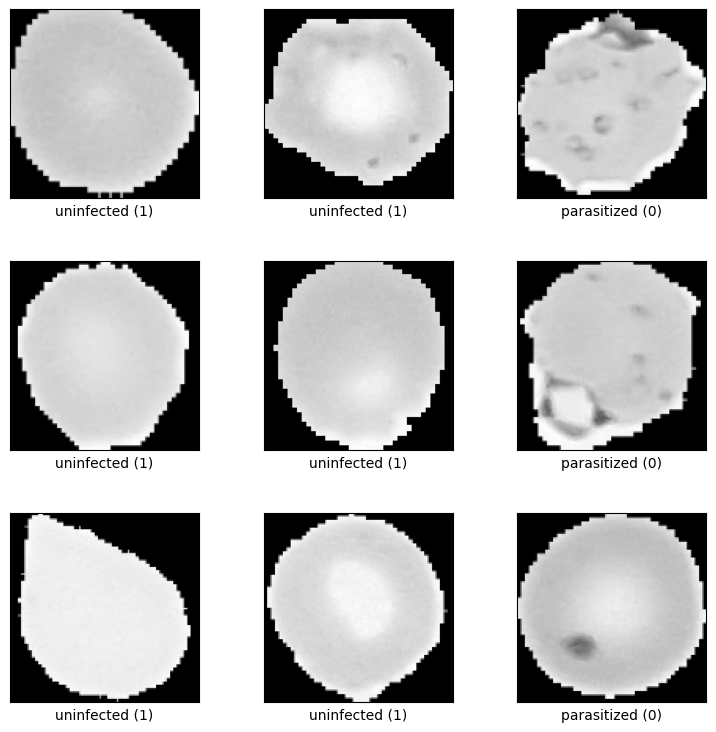

In [389]:
def convert_color_dataset_to_grayscale(ds: Dataset):
    def convert(d):
        image = d['image']
        label = d['label']
        return {
            'image': tf.image.rgb_to_grayscale(tf.image.resize_with_pad(image, 121, 121)),
            'label': label
        }
    return list(map(convert, iter(ds)))

(tfds.show_examples(
    convert_color_dataset_to_grayscale(ds.take(18)),
    info,
    rows=3,
    cols=3));

# Model training and evaluation

To have a clean slate, we reset and (re) import dependencies.

In [390]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import VGG16
from tensorflow.data import Dataset
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.math import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
print('Packages imported successfully');


Packages imported successfully


We convert and partition the dataset into __ds_train__, __ds_test__ and __ds_validate__. 
- batching and prefetching are used for speedup of training
- images are converted to 121x121 grayscale images

In [391]:
AUTOTUNE=tf.data.AUTOTUNE

def load_and_normalize():
    def cvt(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, [121,121])
        image = image / 255.0
        return image, label
    def normalize(ds):
        return ds.map(cvt, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
    (ds_train, ds_test, ds_validate), ds_info = tfds.load(
        'malaria',
        split=["train[0%:20%]", "train[20%:25%]", "train[25%:]"],
        as_supervised=True,
        with_info=True
    )
    return (normalize(ds_train), normalize(ds_test), normalize(ds_validate)), ds_info

(ds_train, ds_test, ds_validate), ds_info = load_and_normalize()

We define a simple infrastructure for caching trained models on disk. This is merely a quality of life improvement while working iteratively and additive in this notebook.

In [392]:
import pickle
import pathlib

def try_load_object(path: str):
    try:
        with open(path, 'rb') as file:
            return pickle.load(file)
    except:
        return None

def save_object(path: str, obj):
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)


All our models share some common characteristics and we we capture that in a model factory.


In [393]:
def compile_malaria_model(model: Model) -> Model:
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Create a model suited for our dataset and classification
def createMalariaModel(hidden_layers: list[Model], **kvargs) -> Model:
    return compile_malaria_model(Sequential([
        # 121x121 images with 1 color channel
        Input(shape=(121, 121, 1)),
        # Model specific hidden layers
        *hidden_layers,
        # Binary classification
        Dense(1, activation="sigmoid")],
        **kvargs))

# Toggle trainability or a (pre-trained) model 
def set_trainable(m: Model, trainable: bool) -> Model:
    m.trainable = trainable
    return m

# utility for setting up convolutional layer
def conv(n: int):
    return Sequential([
        Conv2D(n, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
    ])

# utility for setting up dense layer
def dense(n):
    return Dense(n, activation="relu")


We also went to monitor training times, and we achieve that that with a custom callback.

In [394]:
import time

class EpochTimeCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        # Record start time at the beginning of each epoch
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        # Calculate time taken for this epoch
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)


We are now ready to introduce our hero classes that captures training, evaluation and presentation in a compact manner.
- the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) strategy is used to prevent overfitting
- model history and weights are cached on disk for reuse

In [395]:
from typing import Self, Callable

class TrainingStats:
    history: History
    epoch_times: list[float]
    def __init__(self, history: History, epoch_times: list[float]):
        self.history = history
        self.epoch_times = epoch_times

class ModelInfo: 
    patience: int
    def __init__(self, patience: int, label_names: list[str]):
        self.patience = patience
        self.label_names = label_names
    def get_patience(self) -> int:
        return self.patience
    def get_label_names(self):
        return self.label_names


def try_load_model_and_training_stats(folder: str) -> tuple[Model, TrainingStats]:
    ts = try_load_object(f'{folder}/training_stats.pkl')
    return (tf.keras.models.load_model(f'{folder}/model.keras'), ts) if ts else (None, None)
    
def save_model_and_training_stats(folder: str, model: Model, ts: TrainingStats):
        save_object(f'{folder}/training_stats.pkl', ts)
        model.save(f"{folder}/model.keras")

class ModelEvaluator:
    @staticmethod
    def create(
            name: str,
            create_model: Callable[[], Model],
            cache_name: str = None,
            train: Dataset = ds_train,
            test: Dataset = ds_test,
            validate: Dataset = ds_validate,
            info = ds_info,
            epochs = 100,
            patience = 2,
    ) -> Self:
        return ModelEvaluator(
            name=name,
            cache_name=cache_name or f'{name}-p{patience}',
            create_model=create_model,
            train=train,
            test=test,
            validate=validate,
            info=info,
            epochs=epochs,
            patience=patience
        )
    @staticmethod
    def create_from_layers(
            name: str,
            hidden_layers: list[Model],
            train: Dataset = ds_train,
            test: Dataset = ds_test,
            validate: Dataset = ds_validate,
            info = ds_info,
            epochs = 100,
            patience = 2        
    ) -> Self:
        return ModelEvaluator.create(
            create_model=lambda : createMalariaModel(hidden_layers),
            name=name,
            train=train,
            test=test,
            validate=validate,
            info=info,
            epochs=epochs,
            patience=patience
        )

    def __init__(
            self,
            name: str,
            cache_name: str,
            create_model: Callable[[], Model],
            train: Dataset = ds_train,
            test: Dataset = ds_test,
            validate: Dataset = ds_validate,
            info = ds_info,
            epochs = 100,
            patience = 2):
        self.name = name
        self.cache_name = cache_name
        self.train = train
        self.test = test
        self.validate = validate
        self.info = info
        self.epochs = epochs
        self.patience = patience

        self.model_info = ModelInfo(patience=patience, label_names=info.features['label'].names)
        (model, training_stats) = try_load_model_and_training_stats(self.get_cache_folder())
        if model and training_stats:
            self.model = model
            self.training_stats = training_stats
            # fix name
            model.name = name
        else:
            model = create_model()
            model.name = name
            self.model = model
            self.training_stats = None

    def get_name(self):
        return self.name
        
    def get_cache_folder(self):
        return f"models/{self.cache_name}"
    
    def get_model(self) -> Model:
        return self.model
    
    def get_model_info(self):
        return self.model_info
    
    def get_training_stats(self) -> TrainingStats:
        self.fit()
        return self.training_stats

    def fit(self):
        model = self.model
        if not self.training_stats:
            timing = EpochTimeCallback()
            history = model.fit(
                self.train,
                validation_data = self.test,
                epochs=self.epochs,
                callbacks=[
                    EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True, verbose=True),
                    TensorBoard(log_dir=f'{self.get_cache_folder()}/logs', histogram_freq=1),
                    timing
                ])
            ts = TrainingStats(history, timing.epoch_times)
            save_model_and_training_stats(self.get_cache_folder(), model, ts)
            self.training_stats = ts
        return self
    
    def get_training_time(self) -> float:
        self.fit()
        return np.array(self.training_stats.epoch_times).sum()

    def get_epoch_times(self) -> float:
        self.fit()
        return self.training_stats.epoch_times

    def get_confusion_matrix(self):
        self.fit()
        cache_name = f"{self.get_cache_folder()}/confusion_matrix.pkl"
        m = try_load_object(cache_name)
        if m is None:
            l = []
            p = []
            for images, labels in self.validate.take(-1): # note: we are iterating over batches
                l.extend(labels.numpy())
                p.extend(np.round(self.model.predict(images, verbose=0)).flatten())
            m = (confusion_matrix(l, p, dtype=float) / len(l)).numpy()
            save_object(cache_name, m)
        return m
    
    def get_predictions(self):
        self.fit()
        cache_name = f"{self.get_cache_folder()}/predictions.pkl"
        m = try_load_object(cache_name)
        if m is None:
            l = []
            p = []
            for images, labels in self.validate.take(-1): # note: we are iterating over batches
                l.extend(labels.numpy())
                p.extend(self.model.predict(images, verbose=0).flatten())
            m = {'labels': l, 'predictions': p}
            save_object(cache_name, m)
        return m['labels'], m['predictions']    
        

We also create utilities for nice plotting of
- training history
- confusion matrix
- precision/recall

In [396]:
class ModelPlot:
    def summary(self, model: ModelEvaluator):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
        self.historyplot(model, ax[0])
        self.confusionmatrixplot(model, ax[1])
        self.precisionrecallplot(model, ax[2])
        plt.show()

    def historyplot(self, model: ModelEvaluator, ax):
        '''
        Plot training metrics as lines
        Show name, accuracy and early stopping epoch
        '''
        ts = model.get_training_stats()
        h = ts.history.history
        actual_epochs = len(h['accuracy'])
        used_epoch = actual_epochs - model.get_model_info().get_patience()
        accuracy=h['accuracy'][used_epoch]                            
        sns.lineplot(h, ax=ax)
        ax.set_title(f"{model.get_name()} training, accuracy={accuracy:.3f}")
        ax.axvline(x = used_epoch-1, color='k', linestyle='--')
        ax.text(used_epoch-1+0.1, 0.5, 'Early stopping', rotation=90)
        return self

    def confusionmatrixplot(self, model: ModelEvaluator, ax):
        '''
        Plot confusion matrix
        '''
        cm = model.get_confusion_matrix()
        annot = np.asarray([f"{v1}\n{v2}" for v1, v2 in zip(['TP','FP','FN','TN'], [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)])]).reshape(2,2)
        labels = model.get_model_info().get_label_names()
        sns.heatmap(cm, 
                    yticklabels=labels,
                    xticklabels=labels,
                    annot=annot,
                    fmt='', ax=ax, cmap='Blues', cbar=False
                    ).set(ylabel='Predicted', xlabel='Actual')
        ax.set_title(f'{model.get_name()} confusion matrix')
        return self
    
    def precisionrecallplot(self, model: ModelEvaluator, ax):
        '''
        Plot precision/recall
        '''
        labels, predictions = model.get_predictions()
        precision, recall, thresholds = precision_recall_curve(labels, predictions)
        sns.lineplot(x=recall, y=precision, ax=ax).set(xlabel='Recall', ylabel='Precision')
        ax.set_title(f'{model.get_name()} precision/recall')

        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold_index = np.argmax(f1_scores)
        best_f1 = f1_scores[best_threshold_index]
        sns.scatterplot(x=[recall[best_threshold_index]], y=[precision[best_threshold_index]], color='red', label=f'Best Threshold (F1 = {best_f1:.2f})', ax=ax)
        return self

We create 3 models:
- __simple-0__ is simple CNN
- __naive__ is somewhat more complex than __simple__0
- __vgg16-based__ is composed around a pretrained, general purpose VGG16 model

In [397]:
models = [
    ModelEvaluator.create_from_layers(
        name='simple-0',
        hidden_layers=[
            conv(32),
            conv(64),
            conv(64),
            Flatten(),
            dense(32)
        ]
    ),
    ModelEvaluator.create_from_layers(
        name='naive',
        hidden_layers=[
            conv(32),
            conv(64),
            conv(128),
            Flatten(),
            dense(64)
        ]
    ),
    ModelEvaluator.create_from_layers(
        name='vgg16-based',
        hidden_layers=[
            Conv2D(3, (3, 3), padding='same'),
            set_trainable(VGG16(weights='imagenet', include_top=False, input_shape=(121, 121, 3)), False),
            GlobalAveragePooling2D(),
            Dense(128, activation='relu')
        ]
    )
]


Our models are compiled, trained and below are the training metrics and confusion matrices.
- The actual epoch used for early stopping marked with a vertical line
- The best accuracy is achieved with the __naive__ model
- False negative ratio is smallest for the __naive__ model

<Figure size 640x480 with 0 Axes>

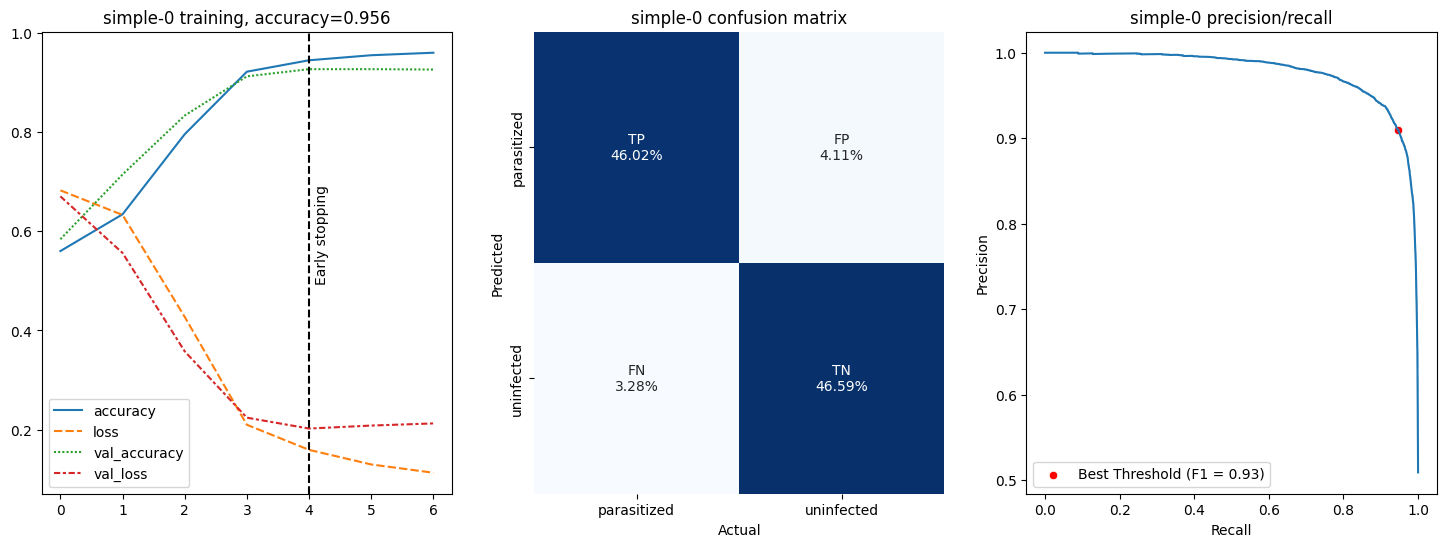

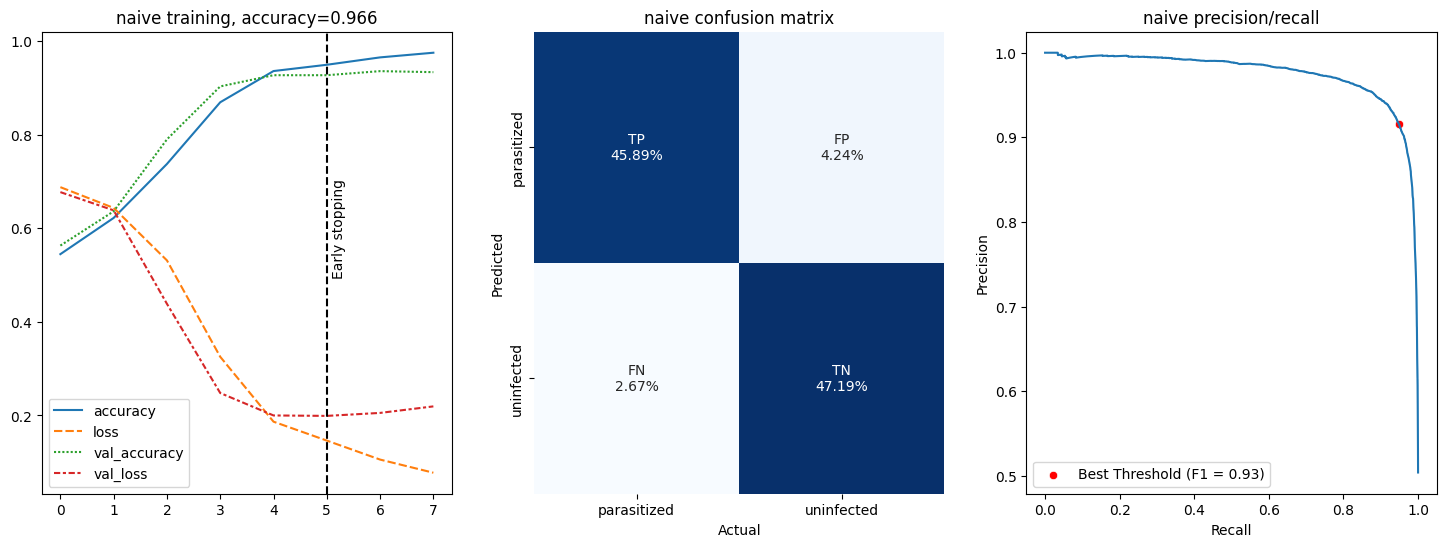

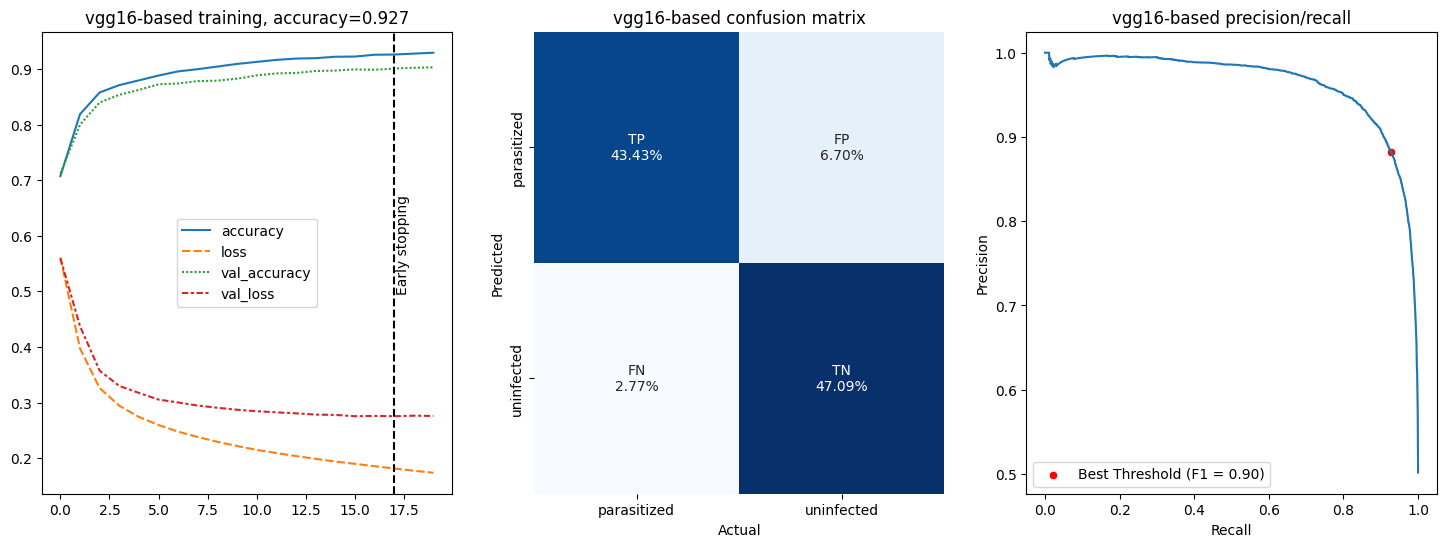

In [398]:
plt.tight_layout()
for index, model in enumerate(models):
    ModelPlot().summary(model)

For partical reasons, training time can be a relevant factor when comparing multiple models.
__simple-0__ and __naive__ outperforms __vgg16-based__.


<Axes: label='total_time', title={'center': 'Total training time'}>

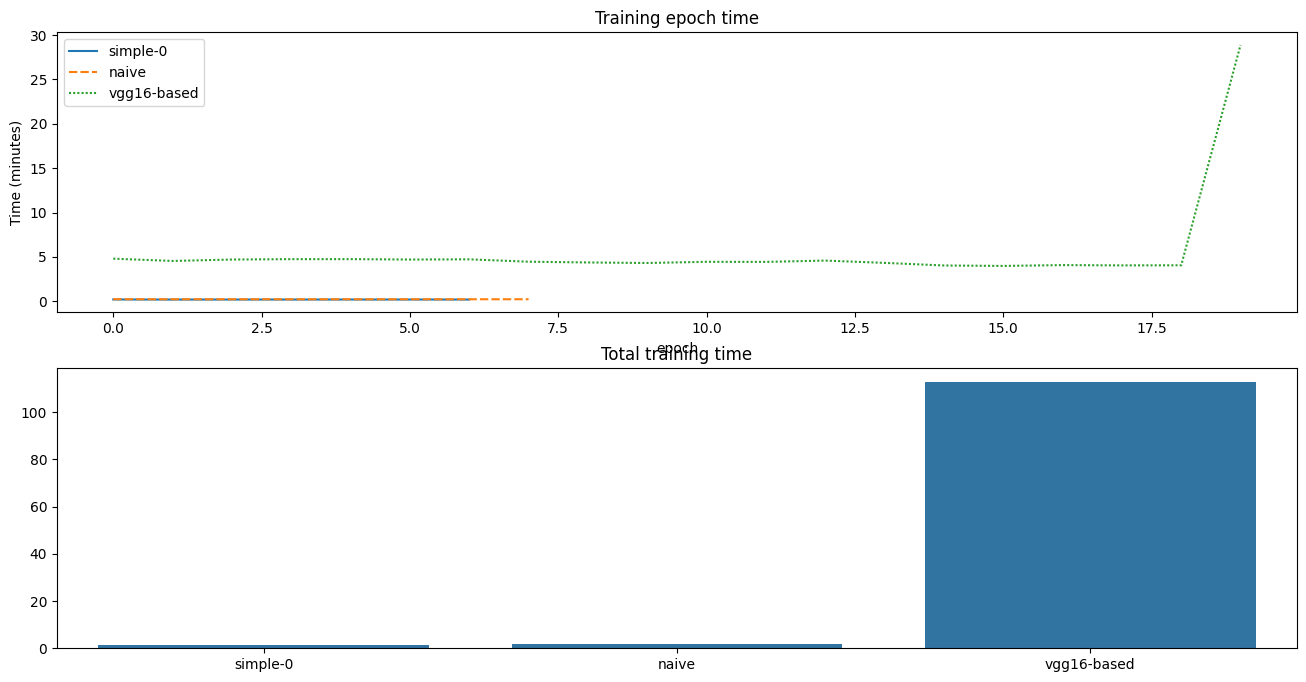

In [399]:
fig, ax = plt.subplot_mosaic([
    ['epoch_times' for m in models],
    ['total_time' for m in models]],
    figsize=(16,8))

ax['epoch_times'].set_title('Training epoch time')
ax['epoch_times'].set(xlabel='epoch', ylabel='Time (minutes)')
sns.lineplot({m.name: np.array(m.get_epoch_times()) / 60.0 for m in models }, ax=ax['epoch_times'])

ax['total_time'].set_title('Total training time')
sns.barplot({m.name: m.get_training_time()/60.0 for m in models}, ax=ax['total_time'])



__naive__ has good characteristics when it comes to
- training time
- accurary
- recall and F1 score

Based on that observervation, we investigate if we can do better.
The general composition of a __naive__-like model is to

- input shaping: 121x121 grayscale images
- some convolutional layers (Convolutional2d + MaxPooling2d)
- flattening
- some dense layers
- a final output layer with sigmoid activation for binary classification

Below we do a randomized search amongst models that follows the above structure with different parametrization when it comes to
- the number of convolutional layers
- the kernel size of individual convolutional layers
- the number of dense layers
- the kernel size of individual dense layers

In [400]:
import keras_tuner
from keras_tuner import HyperParameters

def create_keras_tuner_model(hp: HyperParameters) -> Model:
    n_conv = hp.Choice('n_conv', [1,2,3,4])
    conv_dims = [hp.Choice(f'c{i}', [16,32,64,128]) for i, n in enumerate(range(0, n_conv))]
    n_dense = hp.Choice('n_dense', [1,2,3])
    dense_dims = [hp.Choice(f'd{i}', [16,32,64,128]) for i, n in enumerate(range(0, n_dense))]
    print({
        'n_conv': n_conv,
        'n_dense': n_dense,
        'conv_dims': conv_dims,
        'dense_dims': dense_dims
    })
    hidden_layers = [
        *[conv(n) for n in conv_dims],
        Flatten(),
        *[dense(n) for n in dense_dims]
    ]
    return createMalariaModel(hidden_layers=hidden_layers)

tuner = keras_tuner.RandomSearch(
    create_keras_tuner_model,
    seed=1337,
    objective='accuracy',
    max_trials=20,
    directory='.tmp',
    overwrite=False,
    project_name='.keras_tuner'
    )

tuner.search(
    ds_train,
    epochs=100,
    validation_data=ds_validate,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=True)]
    )


Reloading Tuner from .tmp/.keras_tuner/tuner0.json


Based on the trials, we print out the best found model.

In [405]:
tuner.get_best_models()[0].summary()

{'n_conv': 3, 'n_dense': 3, 'conv_dims': [16, 32, 128], 'dense_dims': [64, 32, 16]}


/Users/joakimlarsson/github/tfds-malaria/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 59, 59, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,428,929 (5.45 MB)

 Trainable params: 1,428,929 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

The best found parameters are

In [402]:
best_hyper_parameters = tuner.get_best_hyperparameters()[0]
print(best_hyper_parameters.values)

{'n_conv': 3, 'c0': 16, 'n_dense': 3, 'd0': 64, 'c1': 32, 'c2': 128, 'd1': 32, 'c3': 128, 'd2': 16}


Below we create a model based on the best found parametrization from the trials and compare it to the __naive__ model.

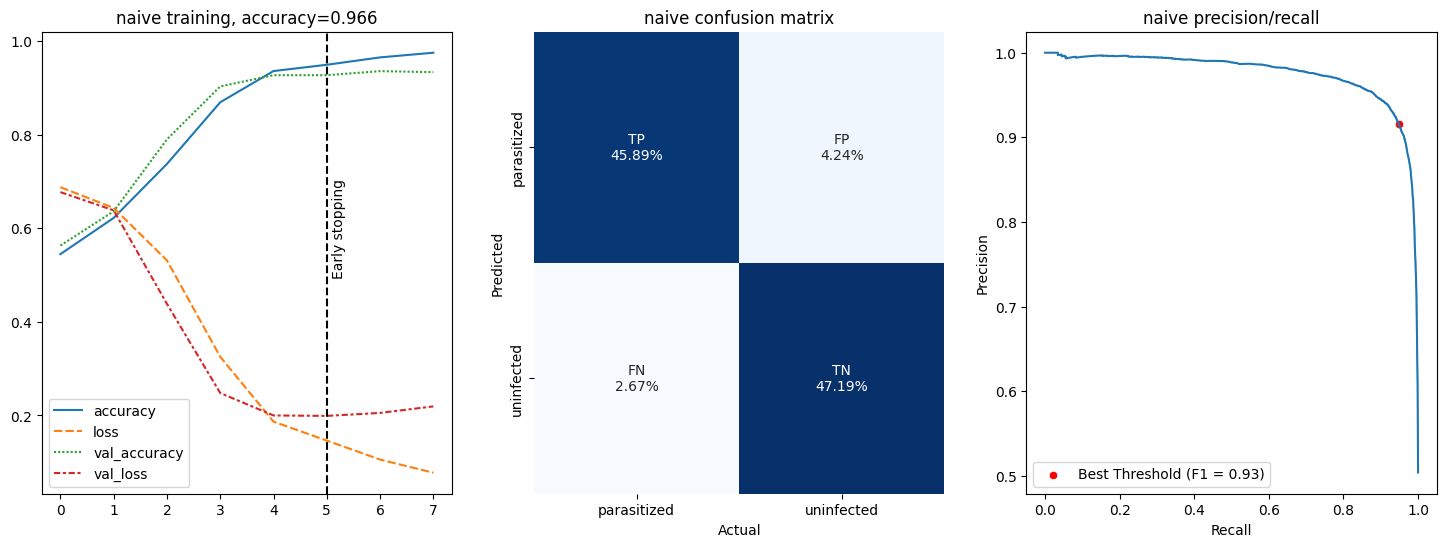

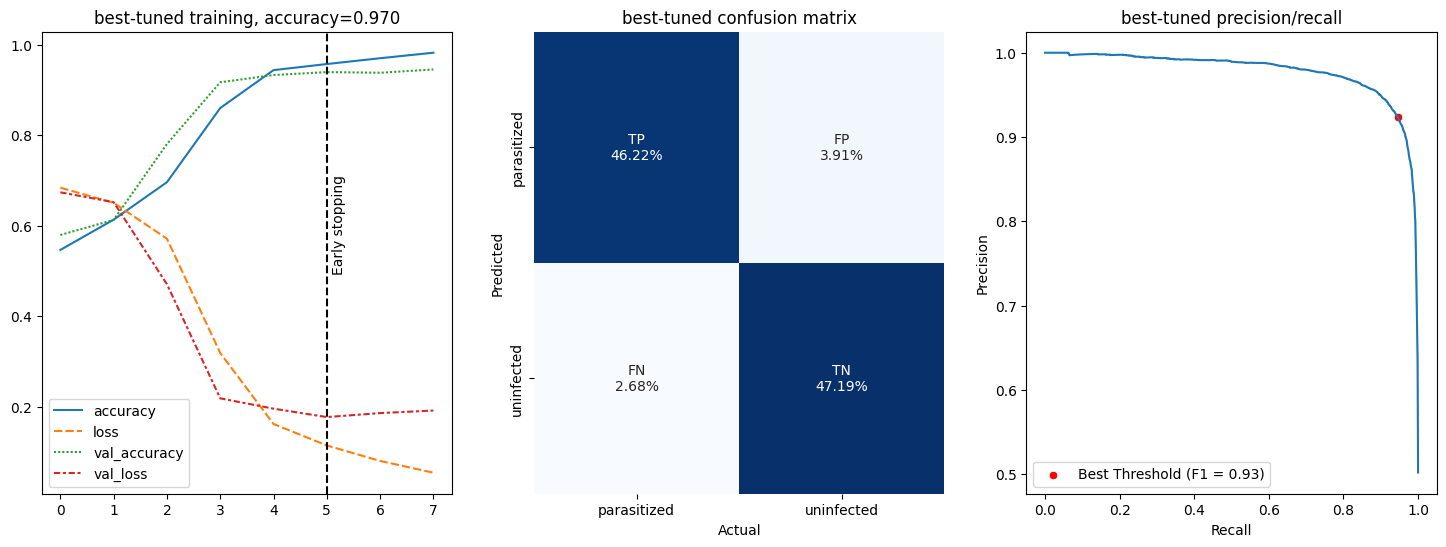

In [403]:
best_model = ModelEvaluator.create_from_layers(
    name='best-tuned',
        hidden_layers=[
            conv(16),
            conv(32),
            conv(128),
            Flatten(),
            dense(64),
            dense(32),
            dense(16)
        ]
)
for m in [m for m in models if m.name == 'naive'] + [best_model]:
    ModelPlot().summary(m)

We see from above that the model found in the trial is equally good or better in every score except false negatives, which is neglible.
To actual preformance with regards to _precision_, _recall_ and _F1 score_ are printed below.

In [404]:
def print_performance_metrics(cm):
    [tp, fp, fn, tn] = cm.flatten()
    precision = tp/(tp + fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision*recall) / (precision + recall)
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'F1 score: {f1}')

print_performance_metrics(best_model.get_confusion_matrix())


precision: 0.9219262599945068
recall: 0.9452800154685974
F1 score: 0.9334570921433862
